In this notebook we will optimize a portfolio and forecast the future prices of this portfolio. This notebook tests it only for a few stocks but can easily be adjusted for more stocks. 

In [34]:
# Download the libraries 
from datetime import datetime
import yfinance as yf
import pandas as pd 
import numpy as np 

from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

import numpy as np
import pandas as pd
import plotly.express as ply
import matplotlib.pyplot as plt 
import seaborn as sb
from datetime import date

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')



Functions for optimization

In [18]:
def get_data(startdate, enddate, stocklist): 
    """
    * This function retrieves the Adjusted close price from the historical data 
      for each stock in the list, for the given date range.
    * Enter dates as "yyyymmdd". 
    """
    start_date=datetime.strptime(startdate, '%Y%m%d').date()
    end_date=datetime.strptime(enddate, '%Y%m%d').date()
    data = yf.download(stocklist, start=start_date, end=end_date, progress=False)
    return data['Adj Close'].copy()


In [19]:
def optimize_portfolio(dataframe, method='sharpe'): 
    """
    The function takes a datafame containing historical stock prices and an optional string argument 'method'
    representing the optimization method. You can choose from two options: 
        * 'sharpe':  (default) Optimize the portfolio for the the highest Sharpe ratio; 
        * 'risk': Optimize the portfolio for the the highest return for a given target risk;
    The function returns the expected annualized return, the annualized volatility, the Sharpe ratio of the portfolio and a dictionary containing the optimized portfolio weights. 
    """
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(dataframe)
    S = risk_models.sample_cov(dataframe)

    # Obtain the efficient frontier
    ef = EfficientFrontier(mu, S)

    # Select a chosen optimal portfolio
    if method == 'sharpe':
        raw_weights = ef.max_sharpe()
    elif method == 'risk':
        user_input = float(input("Enter desired volatility (must be above 0.2): "))
        if user_input <= 0.2:
            raise ValueError("Please enter a volatility above 0.2)")
        raw_weights = ef.efficient_risk(user_input)
    else:
        raise ValueError("Please enter a valid input for method (sharpe, risk)")

    cleaned_weights = ef.clean_weights()

    # Store the portolio performance numbers in variables
    ear, av, sr = ef.portfolio_performance()

    return cleaned_weights, ear, av, sr

def info(df, method='sharpe'):
    """
    This function shows the following portfolio numbers: 
    * return
    * volatility
    * Sharpe ratio
    """
    # Optimize the portfolio 
    weights,ear,av,sr=optimize_portfolio(df,method)
    # Print performance numbers
    print(f'Expected annual return: {ear.round(2)*100}%')
    print(f'Annual volatility: {av.round(2)*100}%')
    print(f'Sharpe ratio: {sr.round(2)*100}%')

def number_of_stocks_to_buy(df, method='sharpe'):
    investment = float(input("Enter the investment amount ($): "))
    if investment != '' :
        # Optimize the portfolio 
        weights, ear, av, sr = optimize_portfolio(df,method)
        # Get latest stock prices (last row) 
        latest_prices = get_latest_prices(df)
        discrete_allocation = DiscreteAllocation(weights, latest_prices , total_portfolio_value = float(investment))
        allocation , leftover = discrete_allocation.lp_portfolio()

        allocation_list = []

        for symbol in allocation:
            allocation_list.append(allocation.get(symbol))

        portfolio_df = pd.DataFrame(list(allocation.items()), columns=['Stock', '# stocks to buy'])
        portfolio_df['Price per stock'] = np.round(latest_prices.loc[portfolio_df['Stock']].values,2)
        portfolio_df['Total'] = portfolio_df['# stocks to buy'] * portfolio_df['Price per stock']
        total=round(portfolio_df.Total.sum(),2)
        left=round(investment-total,2)
        print('Number of stocks to buy with the amount of $ ' + str(investment))
        print(portfolio_df)
        print(f"Total paid for this portfolio: ${total}. Remaining funds : $ {left}")

def pie_plot(df, method='sharpe'): 

    weights,ear,av,sr=optimize_portfolio(df,method)

    # Filter out the zero values from the dictionary
    nonzero_weights = {k: v for k, v in weights.items() if v != 0}

    # Convert the weights to percentages
    total_weight = sum(nonzero_weights.values())
    percentages = [100 * v / total_weight for v in nonzero_weights.values()]

    # Create a list of labels for the pie chart
    labels = list(nonzero_weights.keys())

    # Plot the pie chart
    fig, ax = plt.subplots()
    ax.pie(percentages, labels=labels, autopct='%1.1f%%')
    ax.set_title('Cleaned Weights')

    return plt.show()

def optimal_df(df, method='sharpe'): 
    """
    This function returns the stock prices of the selected stocks by 
    the chosen optimalization method. It will also add a column with the 
    stock prices depending on the (optimal) weights. 
    """
    # df=df.copy()
    weights,ear,av,sr=optimize_portfolio(df,method)
    selected_stocks = [k for k, v in weights.items() if v != 0]
    df_selected=df[selected_stocks]
    df_selected['Best portfolio'] = 0

    for symbol, weight in weights.items():
        if weight !=0:
            df_selected['Best portfolio'] += df_selected[symbol]*weight
    
    return df_selected

def plot_returns(df):  
    """
     function takes a dataframe, calculates its daily and cumulative returns,
     and returns a line plot of the cumulative returns over time. You can 
     see how the investment of 100 $ will evolve over time. 
    """
    #Calculate dailty return
    d_returns = df.pct_change().dropna() 
    #Daily cumulative returns 
    d_cum_returns = (1 + d_returns).cumprod()*100
    fig = ply.line(d_cum_returns, title="Cumulative returns of stocks with initial investment of $100")
    return fig





Functions for prediction

In [30]:
def split(df,date): 
    """This function divides the dataframe in a train
    and test test splitted by the date given.
    """
    train=df.loc[df.index<date]
    test=df.loc[df.index>=date]
    return train, test

def plot_close(df, date):
    """
    In this function you can enter a date as 'yyyymmdd' and 
    see the plot of train and test  
    """
    train,test= split(df,date)

    fig, ax = plt.subplots(figsize=(20, 5))
    train.plot(ax=ax, label='Training', title='Adjusted Closing Prices')
    test.plot(ax=ax, label='Test Set')
    ax.axvline(date, color='black', ls='--')
    ax.legend(['Training', 'Test'])
    plt.show()

def prepare_data(df, date):
    # Add lag to the DataFrame
    df_lagged = df.copy()
    df_lagged['t-1'] = df_lagged['Best portfolio'].shift(1)
    df_lagged['t-2'] = df_lagged['Best portfolio'].shift(2)
    df_lagged.dropna(inplace=True)
    
    # Split the DataFrame into train and test sets
    train,test= split(df_lagged,date)
    
    # Split the train and test sets into features and target
    X_train = train[['t-1', 't-2']]
    y_train = train['Best portfolio']
    X_test = test[['t-1', 't-2']]
    y_test = test['Best portfolio']
    
    # Combine train and test sets into X and y
    X = df_lagged[['t-1', 't-2']]
    y = df_lagged['Best portfolio']
    
    return X_train, X_test, y_train, y_test, X, y

def predict_head(X):
    """
    CAREFUL!!
    This function will only predict the future 5 business days 
    as from January 1st, 2023.  
    """
    date_list = [pd.to_datetime('2023-01-03'), pd.to_datetime('2023-01-04'), pd.to_datetime('2023-01-05'), pd.to_datetime('2023-01-06'), pd.to_datetime('2023-01-09')]
    start_values = {'t-1': xgb.predict(X.iloc[-1:])[0], 't-2': X.iloc[-1,0]}

    # Loop over the next five days
    for day in date_list:
        values = {'t-1': xgb.predict(X.iloc[-1:])[0], 't-2': X.iloc[-1,0]}
        X = X.append(pd.DataFrame(values, index=[day]))
    
    y_predict=xgb.predict(X.tail())
    return y_predict

As an example we will take the following stock list: Microsoft, Marsh & McLennan Companies, NiSource Inc, Baxter, Centerpoint Energy, Target Corporation, JP Morgan and Boeing. We will read in price data between 1 january 2018 and 1 january 2023. 


Expected annual return: 21.0%
Annual volatility: 24.0%
Sharpe ratio: 79.0%

Number of stocks to buy with the amount of $ 10000.0
  Stock  # stocks to buy  Price per stock    Total
0   MMC               22           164.92  3628.24
1  MSFT               19           239.22  4545.18
2   TGT               12           148.11  1777.32
Total paid for this portfolio: $9950.74. Remaining funds : $ 49.26
Let's see how your basket looks like: 


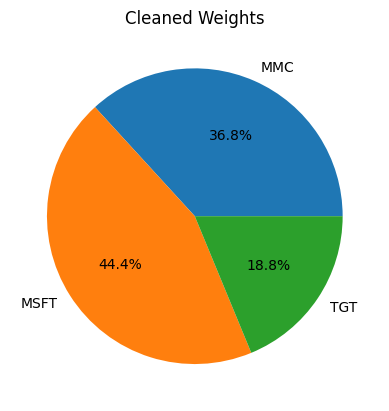

Here are the most recent stock prices of your stocks and (optimal) portfolio:



,MMC,MSFT,TGT,Best portfolio
Date,,,,
2022-12-23,165.026871,238.133545,142.257996,193.246732
2022-12-27,165.873978,236.367981,144.643051,193.221198
2022-12-28,164.040237,233.944031,144.891479,191.515781
2022-12-29,166.212830,240.407837,147.445465,195.667113
2022-12-30,164.917236,239.220825,148.111282,194.787758



The following graph shows how your investment of 100 dollars would evolve over time


In [31]:
# Enter stocks
stock_list = ['MSFT', 'MMC', 'NI', 'BAX', 'CNP', 'TGT', 'JPM', 'BA']

# Read in price data example between 01 jan 2018 and 01 jan 2023
df = get_data("20180101","20230101",stock_list)

# Show information about optimal portfolio 
info(df)
print("")
# Enter portfolio amount and show the discrete allocation
number_of_stocks_to_buy(df)
print("Let's see how your basket looks like: ")
pie_plot(df)
print("Here are the most recent stock prices of your stocks and (optimal) portfolio:")
print("")
df_opt=optimal_df(df)
display(df_opt.tail())
print("")
# Plot the daily returns showing how an investment of 100 dollars would evolve
print("The following graph shows how your investment of 100 dollars would evolve over time")
plot_returns(df_opt)



The original dataset consisted of closing times for 8 stocks but the latest dataframe shows only the selected stocks according to the model. It also shows the weighted stock price for the portfolio. We will now predict the future prices of this portfolio. 

In a first instance we'll divide the dataset at date 1 dec 2022. 

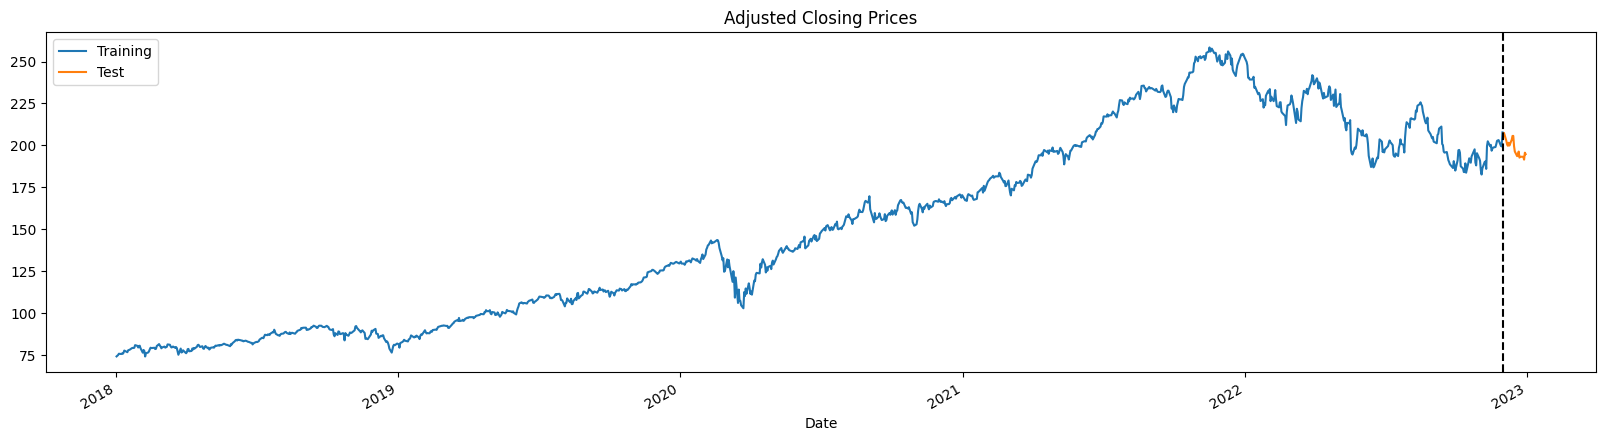

In [46]:
close_df=df_opt[['Best portfolio']]
# We will split the data in train and test set and plot the stock price
date="20221201"
plot_close(close_df, date)

In [48]:
#Store all the values
X_train, X_test, y_train, y_test, X, y=prepare_data(close_df, date)


We'll use Gridsearch in order to find the best parameters. We will check the RMSE-score and plot the prediction.

In [50]:
model = XGBRegressor()
model.fit(X_train, y_train)

param_grid = {
    
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

In [51]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [52]:
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=500, early_stopping_rounds=50, learning_rate=0.01, max_depth=5)
xgb.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test,y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [53]:
y_pred = xgb.predict(X_test)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

RMSE: 2.630185323237101


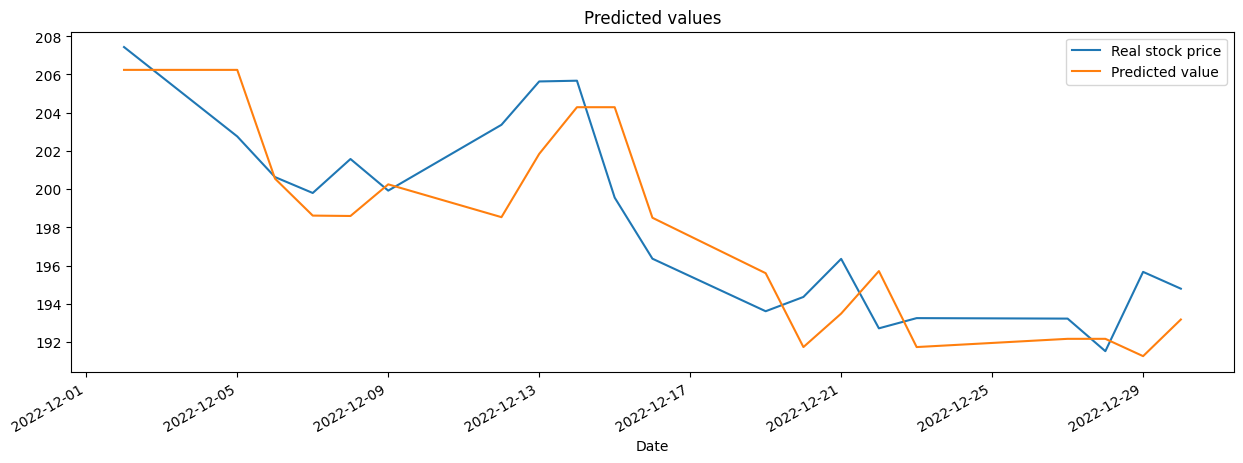

In [57]:
train,test=split(close_df,date)
test['prediction'] = xgb.predict(X_test)
df = close_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df.tail(20)[['Best portfolio']].plot(figsize=(15, 5)) #month
df.tail(20)['prediction'].plot(ax=ax)
plt.legend(['Real stock price', 'Predicted value'])
ax.set_title('Predicted values')
plt.show()

We are happy with the results, hence we can use the whole dataset untill the end of 2022. 

In [58]:
#Finalization
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=500, early_stopping_rounds=50, learning_rate=0.01, max_depth=5)
xgb.fit(X, y, eval_set=[(X, y)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

We can now make a prediction for the 5 coming days

In [63]:
y_predict=predict_head(X)

In [64]:
y_predict

array([191.92635, 191.6277 , 191.6277 , 191.6277 , 191.6277 ],
      dtype=float32)